In [30]:
# Transformers and PyTorch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu116
!pip install transformers==4.35.0

# CLIP
!pip install git+https://github.com/openai/CLIP.git

# FAISS GPU (if you have CUDA)
!pip install faiss-gpu
# FAISS CPU alternative:
# pip install faiss-cpu

# PIL for image handling
!pip install pillow

# Other utilities
!pip install jsonlines numpy


Looking in indexes: https://download.pytorch.org/whl/cu116
  Using cached transformers-4.35.0-py3-none-any.whl.metadata (123 kB)
  Using cached tokenizers-0.14.1-cp38-none-win_amd64.whl.metadata (6.8 kB)
  Using cached huggingface_hub-0.17.3-py3-none-any.whl.metadata (13 kB)
Using cached transformers-4.35.0-py3-none-any.whl (7.9 MB)
Using cached tokenizers-0.14.1-cp38-none-win_amd64.whl (2.2 MB)
Using cached huggingface_hub-0.17.3-py3-none-any.whl (295 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.35.3
    Uninstalling huggingface-hub-0.35.3:
      Successfully uninstalled huggingface-hub-0.35.3
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.0
    Uninstalling transformers-4.44.0:
      Successfully uninstalled transformers-4.44.

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\sarav\AppData\Local\Temp\pip-req-build-q44imrmi'
ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


In [8]:
!pip install matplotlib

   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.8/7.5 MB 4.8 MB/s eta 0:00:02
   --------- ------------------------------ 1.8/7.5 MB 5.0 MB/s eta 0:00:02
   ------------- -------------------------- 2.6/7.5 MB 4.7 MB/s eta 0:00:02
   ------------------ --------------------- 3.4/7.5 MB 4.5 MB/s eta 0:00:01
   ----------------------- ---------------- 4.5/7.5 MB 4.6 MB/s eta 0:00:01
   ----------------------------- ---------- 5.5/7.5 MB 4.6 MB/s eta 0:00:01
   ---------------------------------- ----- 6.6/7.5 MB 4.6 MB/s eta 0:00:01
   ---------------------------------------  7.3/7.5 MB 4.5 MB/s eta 0:00:01
   ---------------------------------------  7.3/7.5 MB 4.5 MB/s eta 0:00:01
   ---------------------------------------- 7.5/7.5 MB 3.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------------- ------------ 1.0/1.5 MB 5.6 MB/s eta 0:00:01
   -----------------------

In [32]:
!pip install h5py

In [2]:
import torch
torch.cuda.empty_cache()
import faiss
import json
import numpy as np
from PIL import Image
from transformers import (
    AutoTokenizer, AutoModel, AutoConfig, AutoModelForCausalLM
)
import clip
import time

# --- Custom imports from your repo ---
from src.utils import prep_strings, postprocess_preds
from src.gpt2 import ThisGPT2Config, ThisGPT2LMHeadModel
from src.vision_encoder_decoder import SmallCap, SmallCapConfig



In [3]:
import os
os.environ["HF_HOME"] = "C:/Users/sarav/.cache/huggingface"


Using device: cpu
Loading GPT2 tokenizer...
Loading SmallCap model...
✅ SmallCap loaded
Loading template...
✅ Template loaded
Loading CLIP feature extractor...
✅ Image loaded: C:\Users\sarav\Downloads\image4.JPG
✅ Prompt prepared
✅ Caption generated in 2.31 seconds


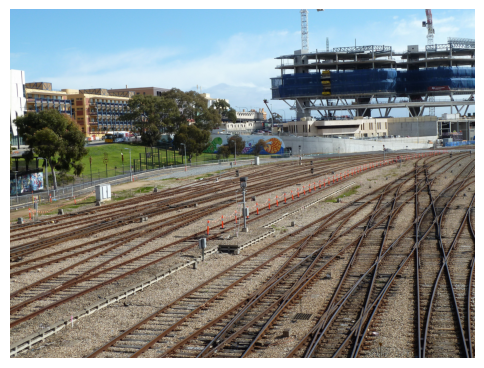

Prompt:
 This image shows 

Generated caption:
 a view of a train track


In [ ]:
import torch
from PIL import Image
import time
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForCausalLM

# --- Force CPU ---
device = "cpu"
print(f"Using device: {device}")

# --- Load GPT2 tokenizer ---
print("Loading GPT2 tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = "!"
tokenizer.eos_token = "."

# --- Register custom models ---
AutoConfig.register("this_gpt2", ThisGPT2Config)
AutoModel.register(ThisGPT2Config, ThisGPT2LMHeadModel)
AutoModelForCausalLM.register(ThisGPT2Config, ThisGPT2LMHeadModel)

AutoConfig.register("smallcap", SmallCapConfig)
AutoModel.register(SmallCapConfig, SmallCap)

# --- Load SmallCap model ---
print("Loading SmallCap model...")
model = AutoModel.from_pretrained(
    "Yova/SmallCap7M",
    torch_dtype=torch.float32,
    low_cpu_mem_usage=True
).to(device)
print("✅ SmallCap loaded")

# --- Load prompt template ---
print("Loading template...")
with open("src/template.txt", "r") as f:
    template = f.read().strip()
print("✅ Template loaded")

import clip
import torch
from PIL import Image

device = "cpu"

# Load CLIP model (we just need the processor)
print("Loading CLIP feature extractor...")
_, feature_extractor = clip.load("ViT-B/32", device=device)

# Load your image
image_path = rf"E:\Projects\smallcap\data\image_truck.jpg"
image = Image.open(image_path).convert("RGB")

# Preprocess image
pixel_values = feature_extractor(image).unsqueeze(0).to(device)

print(f"✅ Image loaded: {image_path}")

# --- Prepare prompt (no retrieved captions) ---
decoder_input_ids = prep_strings(
    "", tokenizer, template=template, retrieved_caps=None, k=0, is_test=True
)
print("✅ Prompt prepared")

start = time.time()
with torch.no_grad():
    pred = model.generate(
        pixel_values.to(device),
        decoder_input_ids=torch.tensor([decoder_input_ids]).to(device),
        max_new_tokens=25,
        no_repeat_ngram_size=0,
        length_penalty=0,
        min_length=1,
        num_beams=3,
        eos_token_id=tokenizer.eos_token_id,
    )
print(f"✅ Caption generated in {time.time() - start:.2f} seconds")

# --- Show results ---
import matplotlib.pyplot as plt
from PIL import Image

# Suppose you already have the PIL image
# image = Image.open(image_path).convert("RGB")

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")  # hide axes
plt.show()

print("Prompt:\n", tokenizer.decode(decoder_input_ids))
print("\nGenerated caption:\n", postprocess_preds(tokenizer.decode(pred[0]), tokenizer))

In [ ]:
import json
import torch
from PIL import Image
from tqdm import tqdm
import clip

device = "cpu"

# Load tokenizer and model (SmallCap)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = "!"
tokenizer.eos_token = "."
model = AutoModel.from_pretrained(
    "Yova/SmallCap7M",
    torch_dtype=torch.float32,
    low_cpu_mem_usage=True
).to(device)

# Load CLIP feature extractor
_, feature_extractor = clip.load("ViT-B/32", device=device)

# Load prompt template
with open("src/template.txt", "r") as f:
    template = f.read().strip()

# Load COCO annotations (subset if desired)
with open("captions_val2014_subset.json") as f:
    coco_data = json.load(f)
images = coco_data["images"][:10]  # top 10 images

# Helper function for prompt prep
def prepare_decoder_input(tokenizer, template, retrieved_caps=None, k=0):
    return prep_strings("", tokenizer, template=template, retrieved_caps=retrieved_caps, k=k, is_test=True)

# Inference loop
results = []
prompt = " what does the image describe?"

for img_info in tqdm(images):
    img_id = img_info['id']
    img_url = img_info.get('coco_url') or img_info.get('flickr_url')

    try:
        from io import BytesIO
        import requests
        response = requests.get(img_url)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    except:
        continue

    pixel_values = feature_extractor(image).unsqueeze(0).to(device)
    decoder_input_ids = prepare_decoder_input(tokenizer, template)

    with torch.no_grad():
        pred = model.generate(
            pixel_values,
            decoder_input_ids=torch.tensor([decoder_input_ids]).to(device),
            max_new_tokens=25,
            no_repeat_ngram_size=0,
            length_penalty=0,
            min_length=1,
            num_beams=3,
            eos_token_id=tokenizer.eos_token_id,
        )

    caption = postprocess_preds(tokenizer.decode(pred[0]), tokenizer)
    results.append({"image_id": img_id, "caption": caption})

# Save results to JSON
with open("results.json", "w") as f:
    json.dump(results, f, indent=2)


In [8]:
!pip install pycocotools

In [17]:
!git clone https://github.com/salaniz/pycocoevalcap.git

Cloning into 'pycocoevalcap'...
Updating files:  80% (32/40)
Updating files:  82% (33/40)
Updating files:  85% (34/40)
Updating files:  87% (35/40)
Updating files:  90% (36/40)
Updating files:  92% (37/40)
Updating files:  95% (38/40)
Updating files:  97% (39/40)
Updating files: 100% (40/40)
Updating files: 100% (40/40), done.


In [1]:
import json
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

# ---------------------------
# 1️⃣ Load a subset of COCO 
# ---------------------------


with open(rf"E:\Projects\smallcap\results.json") as f:
    results = json.load(f)

coco_gt = COCO("captions_val2014_subset.json")


# ---------------------------
# 3️⃣ Run COCO evaluation
# ---------------------------
coco_res = coco_gt.loadRes(results)
coco_eval = COCOEvalCap(coco_gt,coco_res)
coco_eval.evaluate()

# ---------------------------
# 4️⃣ Print metric scores
# ---------------------------
for metric, score in coco_eval.eval.items():
    print(f"{metric}: {score:.4f}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
computing Bleu score...
{'testlen': 771, 'reflen': 886, 'guess': [771, 671, 571, 471], 'correct': [458, 215, 87, 34]}
ratio: 0.8702031602698982
Bleu_1: 0.512
Bleu_2: 0.376
Bleu_3: 0.265
Bleu_4: 0.184
computing METEOR score...
METEOR: 0.172
computing Rouge score...
ROUGE_L: 0.407
computing CIDEr score...
CIDEr: 0.556
computing SPICE score...


CalledProcessError: Command '['java', '-jar', '-Xmx8G', 'spice-1.0.jar', 'e:\\Projects\\smallcap\\pycocoevalcap\\spice\\tmp\\tmp7gwb8cnw', '-cache', 'e:\\Projects\\smallcap\\pycocoevalcap\\spice\\cache', '-out', 'e:\\Projects\\smallcap\\pycocoevalcap\\spice\\tmp\\tmpv9bcv9wm', '-subset', '-silent']' returned non-zero exit status 1.